# Final Project - Display Advertising Challenge
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

__`Andy Carlson, Mark Gin, Michelle Liu, Kathleen Wang`__

## Question Formulation

Display advertising is a type of online advertising that comes in several forms, including banner ad, text billboard, or videos. Display advertising is a billion dollar effort and marketers are always thriving for the most optimal way to target their potential customers.

In this Kaggle competition, CriteoLabs provided a week’s worth of data on the user and the page he is visiting to develop models predicting ad click-through rate (CTR). Given the metrics CriteoLabs collected on the user and the page, our goal is to develop an accurate machine learning algorithm for CTR estimation to predict if the user would click on the ad. 

## Background

We downloaded the large dataset from CriteoLabs:

* train.csv - This file contains 45,840,617 rows, consisting of a portion of Criteo's data over a period of 7 days. Each row corresponds to a display ad, where positive (clicked) and negatives (non-clicked) examples have both been subsampled at different rates to reduce the dataset size. 

* test.csv - The test set for Kaggle submission purposes is computed in the same way as the training set but for events on the day following the training period.

In the data, the first column is a label that indicates if the ad was clicked (1) or not (0). The next 39 columns are undisclosed features - the first 13 columns are integer features, and the next 26 columns are categorial features that are hashed onto 32 bits for anonymization purposes. The fields are left empty when a value is missing.

Since around 75% of the data are labeled 0, our goal is to beat 75% accuracy for our algorithm to be practically useful.

## EDA & Discussion of Challenges

The Criteo Display Advertising dataset that we are provided contains:
1. Data labels
2. Columns 1-13 are numerical data
3. Columns 14-26 are categorical (string) data

All the data has been anonamized, which provides some challenges in of itself, as we will not be able to use any direct human intuition as part of our feature selection.  Aspects we'll want to explore about the data will include checks for missing data points and consideration remedies for missing fields as well as cross-correlation of variables with missing data.

We'll also want to investigate the number categories distribution for the categorical data.  This will be particularly useful in helping to determine if we need to do additional feature engineering and can affect our strategy for predicting labels.

Similar to the categorical data, we want to investigate the distribution of each numerical data field; this can also help guide our decision making on how best to predict Ad Click-Through based on the data provided.

### Starting Spark

In [ ]:
%%bash
pip install missingno

In [1]:
from operator import add
from collections import defaultdict
import csv
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import chi2_contingency
import seaborn as sb
import matplotlib.pyplot as plt
import missingno as msno
plt.style.use("ggplot")

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261_final_eda"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

## Loading Data

Sample the data from the cluster and load some of it into memory. We set our sample size to 10,000 to allow us for easier interpretation of the dataset, as a 40 million entry analysis would be cumbersome for a full analysis.  This is sampled randomly, so it can be considered an unbiased estimator for many of the heuristics about the data.

In [4]:
rawRDD = spark.read.csv("data/train.txt", header=False, sep="\t").rdd
dataRDD = rawRDD.map(lambda row: ([None if el is None else int(el) for el in row[1:14]] + list(row[14:]), int(row[0])))

In [17]:
n = 10000
sample = dataRDD.takeSample(withReplacement=False, num=n)

numeric_columns = np.array([pair[0][:13] for pair in sample], dtype=np.float)
numeric_df = pd.DataFrame(numeric_columns)

category_columns = np.array([pair[0][13:] for pair in sample])
category_df = pd.DataFrame(category_columns)

labels = np.array([pair[1] for pair in sample])

# 1. Data Quality and Distribution

### 1.1 Analyze 13 Numeric Columns

First, see the fraction of missing values for each column. Some are complete, or near complete. Others are mostly missing. 

In [33]:
pd.DataFrame(numeric_df.isna().sum() / n).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.453,0.0,0.2135,0.2115,0.0269,0.2217,0.0412,0.0,0.0412,0.453,0.0412,0.7657,0.2115


Let's also visualize that. This will help to see if the missing values are correlated. Gray means not missing and white means missing.

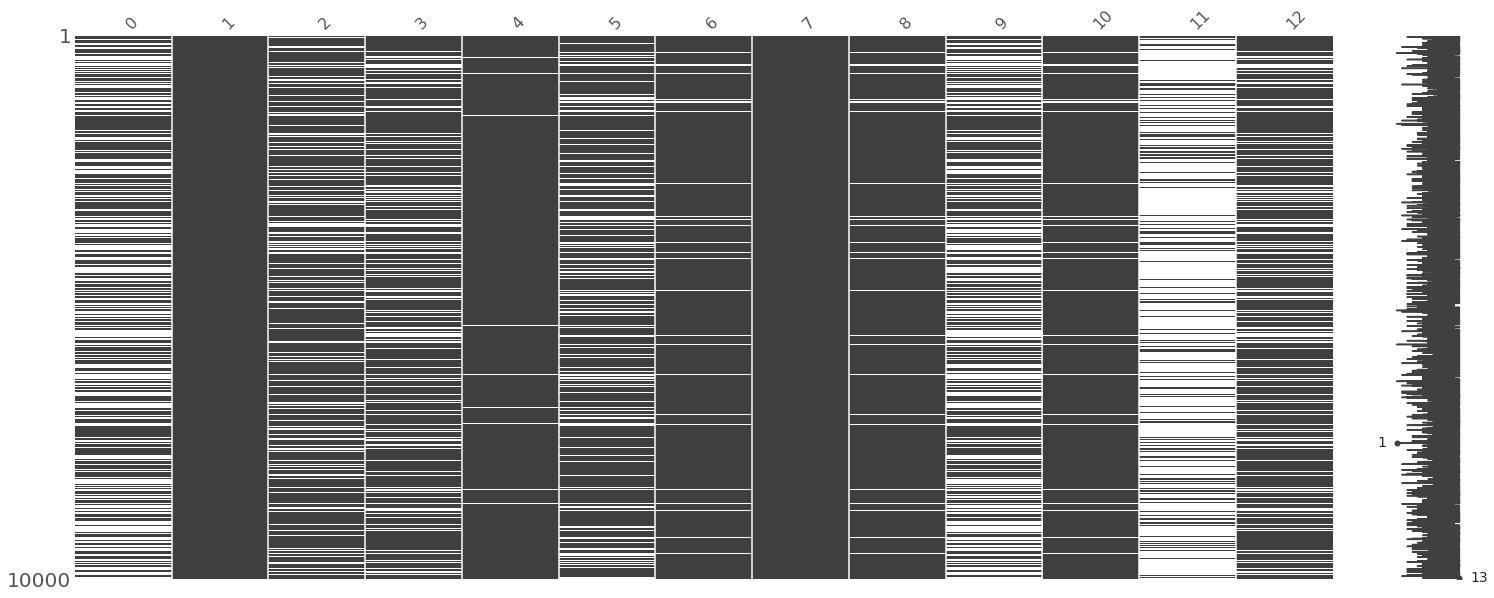

In [7]:
# plot positions of missing values
msno.matrix(numeric_df);

This shows that between some columns, the missing values are correlated, i.e. a value missing in one column affects whether the value is missing oin another. Columns I6 and I8 are perfectly correlated. Others appear to have little correlation. This means removing rows with missing data is infeasible, as it would eliminate nearly the entire dataset.

Next, look at the spread of the values which are present, such as histograms.

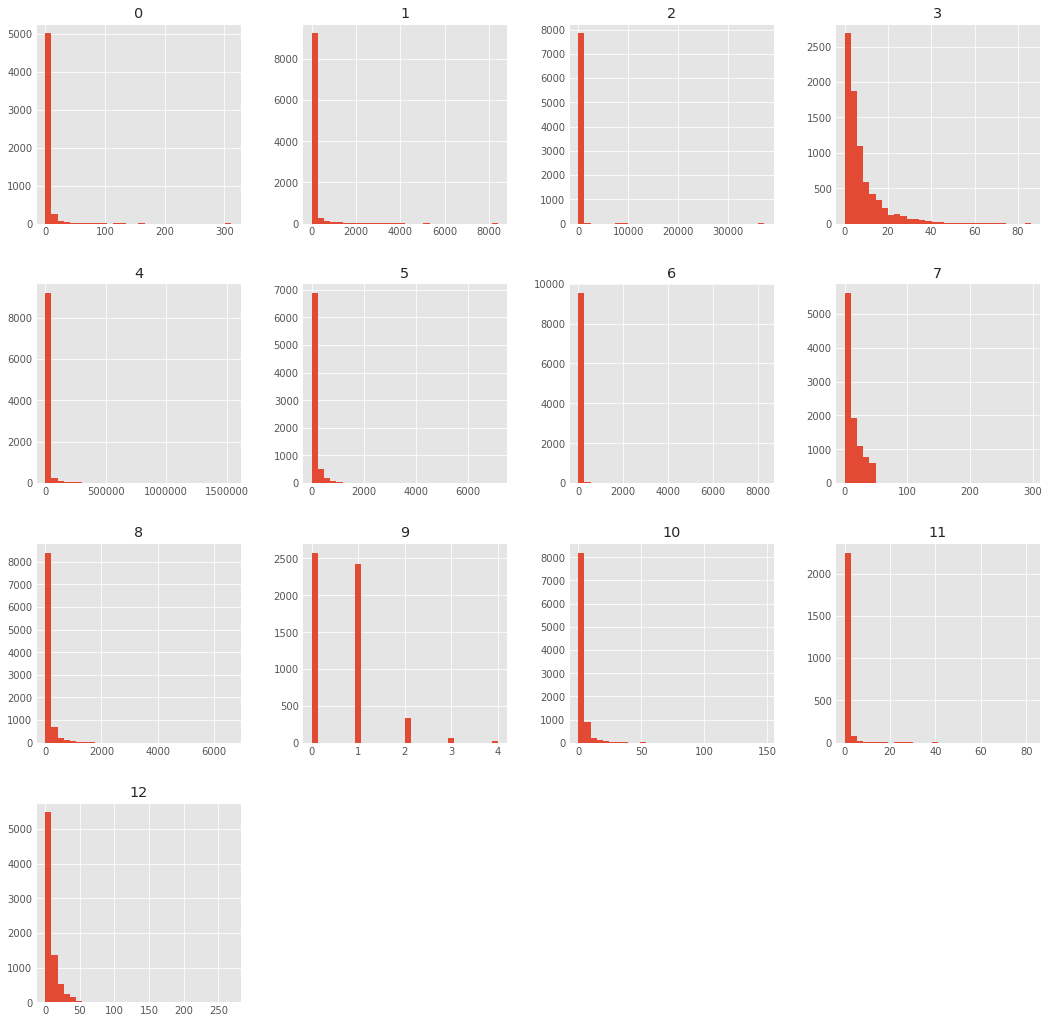

In [9]:
numeric_df.hist(figsize=(18, 18), bins=30);

These are all very right-skewed. This can be undesireable for some models. We might be able to get more normal looking distributions with transforms. Let's also look at a log-transform (and add constant value to avoid issues with 0's). This looks more normal, but the prevalence of 0-values produces a flagrant bi-modality. It would be better to avoid the need for transformation, if practical.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


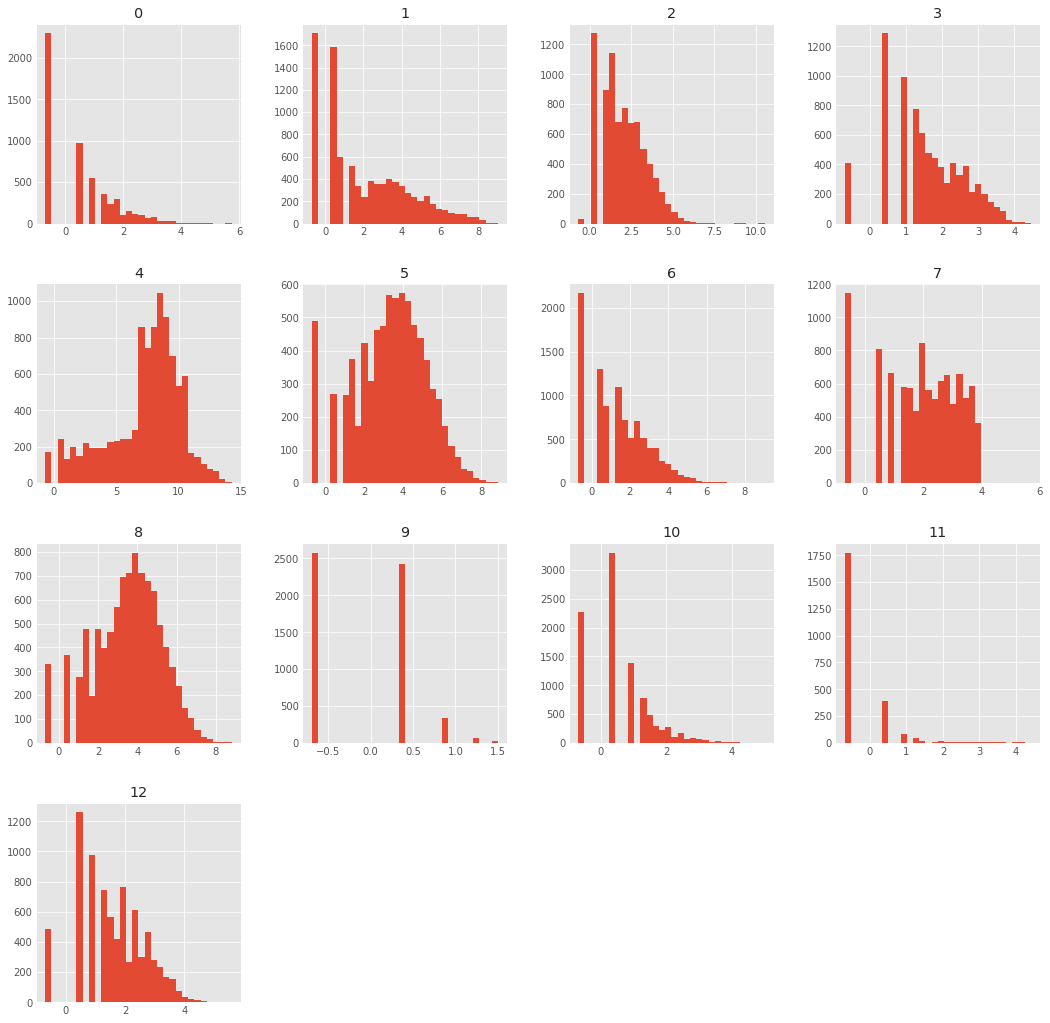

In [10]:
np.log(numeric_df + 0.5).hist(figsize=(18, 18), bins=30);

Let's look at some other aggregate statistics, like quantiles, means, and extremes. This can be used to check for anomalies and potential coding errors. Whoa there are some negative values. Weird! This seems like a very isolated, one-off. It can probably be ignored.

In [13]:
numeric_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,5470.0,3.440219,9.358740,0.0,0.0,1.0,3.0,253.0
1,10000.0,106.062000,379.233449,-2.0,0.0,3.0,37.0,4802.0
2,7929.0,29.992559,537.416622,0.0,2.0,6.0,17.0,37259.0
3,7889.0,7.440994,8.761958,0.0,2.0,4.0,10.0,151.0
4,9753.0,17060.446119,63315.649415,0.0,313.0,2796.0,10150.0,1310303.0
5,7780.0,116.174679,315.746184,0.0,8.0,33.0,105.0,8731.0
6,9600.0,16.902083,88.873733,0.0,1.0,3.0,12.0,4888.0
7,9998.0,12.658132,13.210878,0.0,2.0,8.0,19.0,174.0
8,9600.0,106.736667,212.057648,0.0,11.0,39.0,115.0,4652.0
9,5470.0,0.622121,0.680142,0.0,0.0,1.0,1.0,4.0


Finally, we chck if the features correlate with one another. Only a few seem to be correlated. This is good, as it means there aren't many redundant features.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


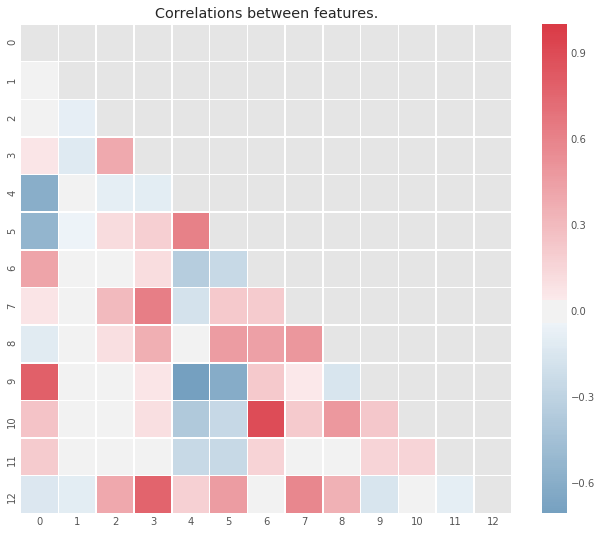

In [12]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = np.log(numeric_df + 0.5).corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(240, 10, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

### Insights

Luckily, the data seems free of coding errors and redundant features. However, there is a lot of missing data, and removing examples with NULL values is impossible. We would also like to avoid having to transform the feature values. Choosing a model that can easily handle NULLs and be scale-invariant seems judicious. Models based on decision trees are promising candidates in this regard.

## Analyze 26 Categorical Columns

Again, start by analyzing for missing values. The categorical data is more complete, and the missing values are more correlated. However, we already know that removing any NULLs is infeasible.

In [45]:
# get percent of missing values for each column

null_df = pd.DataFrame(category_df.isna().sum() / n).T
display(null_df[list(range(0, 15))])
null_df[list(range(15, 26))].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0341,0.0341,0.0,0.1216,0.0,0.0,0.0,0.0,0.0,0.0341,0.0,0.0,0.0


,15,16,17,18,19,20,21,22,23,24,25
0,0.0341,0.0,0.0,0.448,0.448,0.0341,0.7543,0.0,0.0341,0.448,0.448


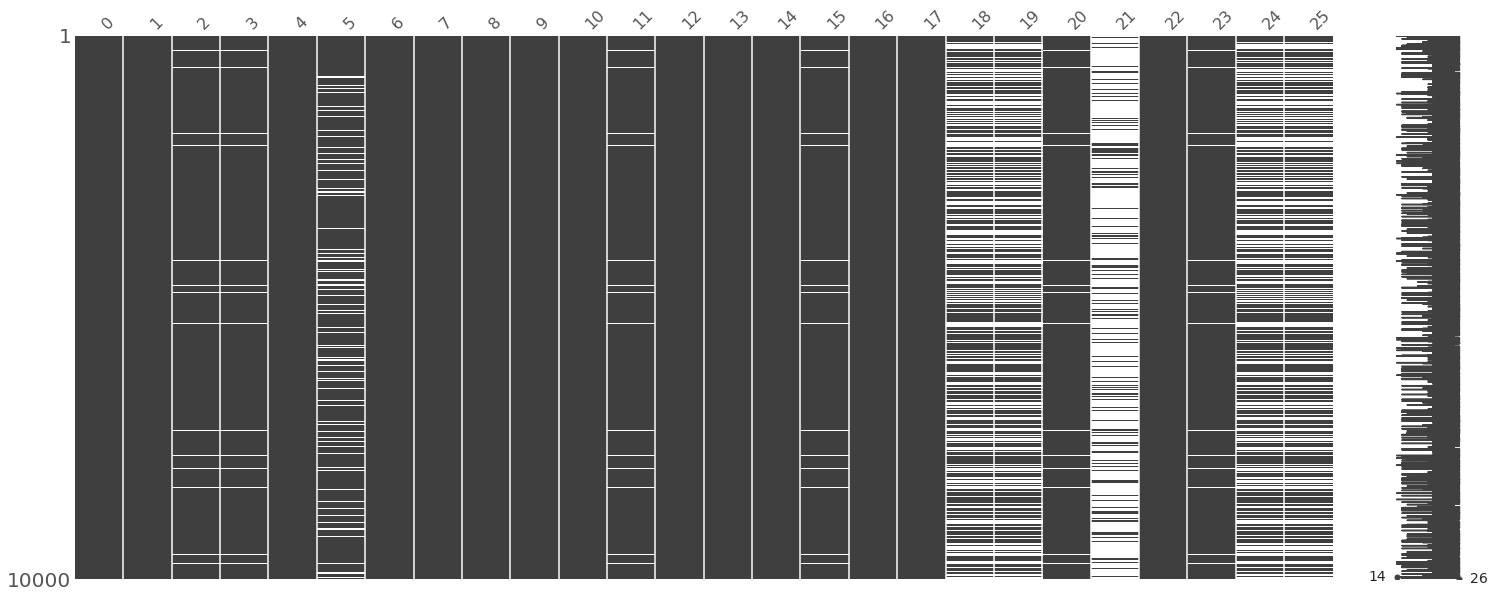

In [14]:
# plot positions of missing values
msno.matrix(category_df);

Next, we want to get an idea of the distribution of the categories. Here, we plot the counts of all the categories that appear in the `C0` column. We see that there are a large number of rare catergories (having a small count)! This is not good, as we need many appearances of a category in order to train parameters on it.

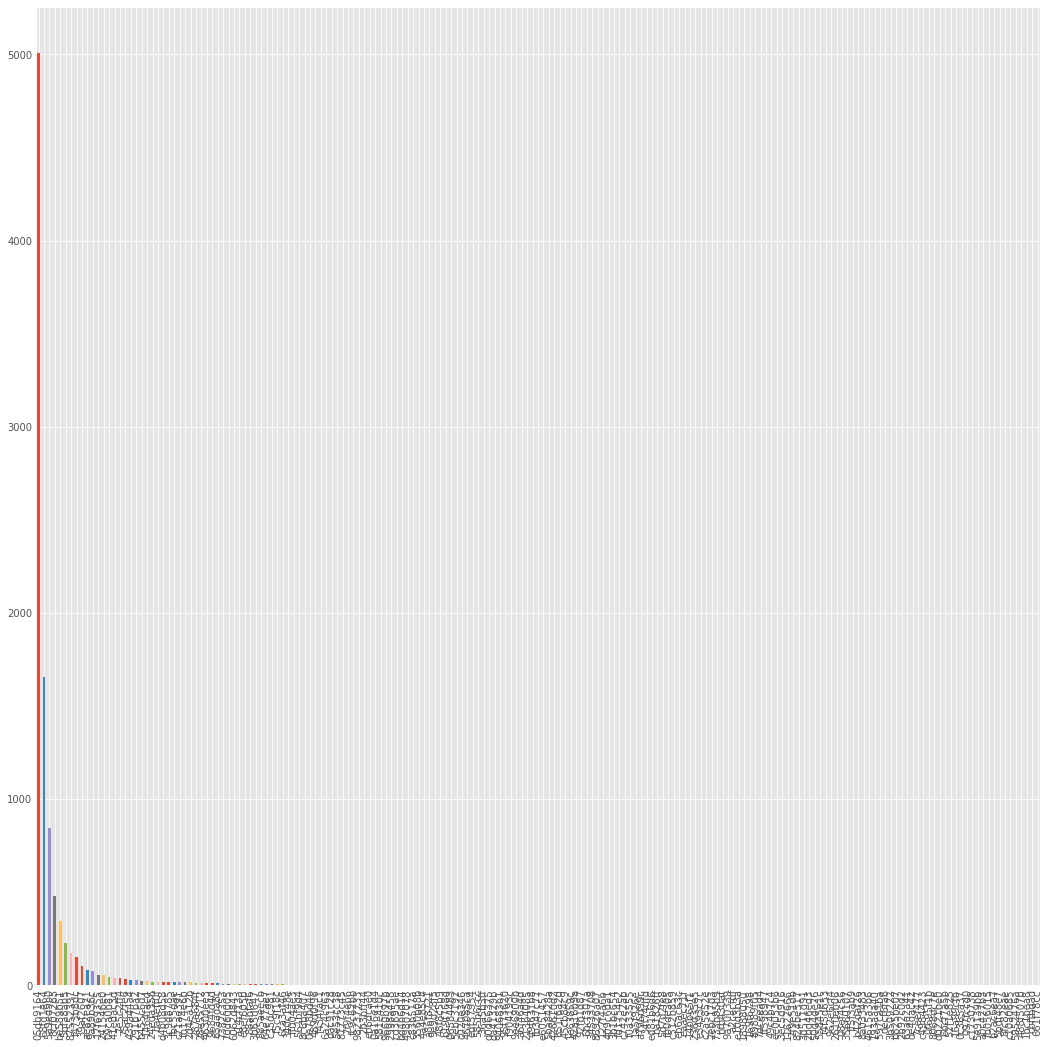

In [16]:
# plot counts for all the possible values of the first column. there are too many categories that appear only once!
counts = pd.value_counts(category_df[0]).plot(kind="bar", figsize=(18, 18))

This table shows more counts for other columns. The "rare category" issue is pretty widespread. Several columns have a very high number of unique columns, and the top most common category is sometimes relatively rare itself (sometimes lower than 0.03% of the examples).

In [17]:
category_df.describe().T

,count,unique,top,freq
0,10000,185,05db9164,5005
1,10000,401,38a947a1,1105
2,9652,5968,d032c263,262
3,9652,4252,c18be181,367
4,10000,54,25c83c98,6667
5,8820,7,7e0ccccf,4041
6,10000,3306,1c86e0eb,208
7,10000,99,0b153874,5981
8,10000,3,a73ee510,8981
9,10000,3307,3b08e48b,2204


Next, plot histograms for the counts. This shows how widespread this rare-category problem is, as mote columns have a huge number of rare classes (classes with a low count). The only ones that seem reasonable to train with are C5, C8, C13, C16, C19, C21, C22, and C24.

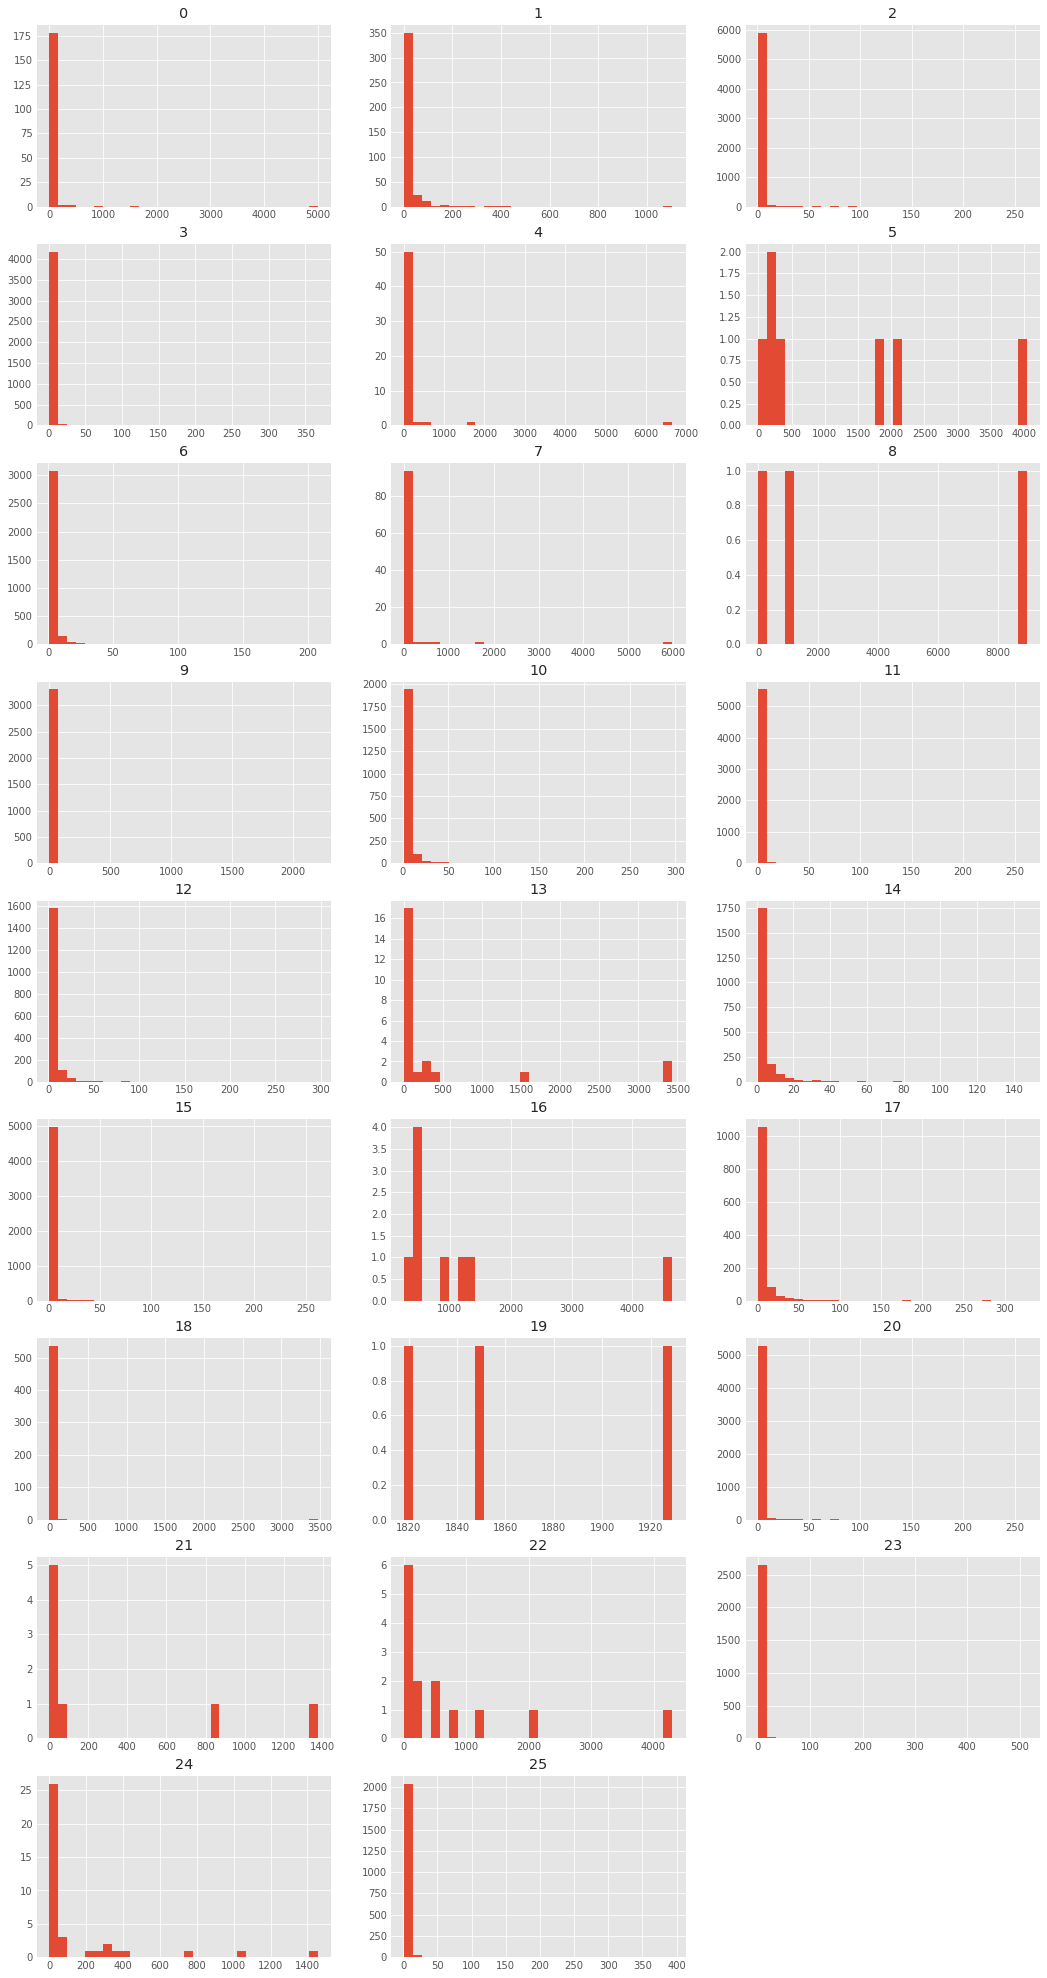

In [18]:
plt.figure(figsize=(18, 4 * len(category_df.columns)))
for i in category_df:
    counts = pd.value_counts(category_df[i])
    plt.subplot(len(category_df.columns), 3, i + 1)
    plt.hist(counts.values, bins=30)
    plt.title(i)

### Insights

Most of the datapoints here are rare categories. Due to the lack of data on them, we cannot use the full variety of categories to train on. Instead, we'll retain only the top-n most common categories within each column, replacing all others with one special value indicating a rare category.

## Analyze Labels

Finally, how the distribution of the labels. This shows that almost 75% of the examples are negative. Since the classes are imbalanced, we need to ensure our evaluation metrics give proper attention to the positive class. Accuracy won't be adequate as the recall and F1 scores for the positive class need to be considered. Resampling or weighting may be required to prevent bias.

In [46]:
np.mean(labels)

0.2562

## Get Top-N Categories for Each Column

We need to figure out which categories are "non-rare" for each column. We'll count up all the categories, filter out any that occur fewer than 10 times, and get the most 50 frequent categories. Later during training, all the other categories will be replaced with the value `"RARE"`. We'll save the categories we select to a CSV file which can be reloaded later.

In [5]:
n = 50

def emit_categories(pair):
    """
    takes each row, and emits one record per categorical column. Emits in a key-value format with 2 tuples:
    (column_name, category_hash), (count_false, count_true, total_count)
    
    count_false is 1 if this row has a 0 label
    count_true is 1 if this row has a 1 label
    these two aren't necessary, but nice to know if the category shows up more frequently in a particular class
    total_count is always 1
    
    these numbers will get reduced and added later
    """
    row, label = pair
    # only loop over the categorical variables
    for i, val in enumerate(row[13:]):
        yield ("C" + str(i), val), (int(label == 0), int(label == 1), 1)

def shift_key(pair):
    """take a 2-tuple key, and make it 1 value instead"""
    (col_name, val), (neg_count, pos_count, total) = pair
    return col_name, (val, neg_count, pos_count, total)

def get_top_n(n):
    """for each group, get the top n by total_count"""
    def mapper(val_seq):
        val_seq = sorted(val_seq, key=lambda x: x[-1], reverse=True)
        return val_seq[:n]
    return mapper
        
category_counts = dataRDD.flatMap(emit_categories) \
    .reduceByKey(lambda tup_a, tup_b: (tup_a[0] + tup_b[0], tup_a[1] + tup_b[1], tup_a[2] + tup_b[2])) \
    .filter(lambda pair: pair[1][-1] >= 10) \
    .map(shift_key) \
    .groupByKey() \
    .mapValues(get_top_n(n)).cache()

num_significant_categories = category_counts.mapValues(len)

In [6]:
category_count_data = defaultdict(dict)

with open("data/freq_category_counts.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["col_name", "category", "neg_count", "pos_count", "total", "category_id"])
    
    # stream the results in to the master
    for row in category_counts.toLocalIterator():
        col_name, category_info = row
        # loop through all the categories and assign an integer ID for each, and save that to the CSV as well
        category_id = 0
        for info in category_info:
            category_name, neg_count, pos_count, total = info
            category_count_data[col_name][category_name] = { "neg": neg_count, "pos": pos_count }
            writer.writerow([col_name, category_name, neg_count, pos_count, total, category_id])
            category_id += 1

Furthermore, we need to know how many categories remain after this filtering (some have fewer than 50). We need to save this too, as sometimes the "arity" of the column jneeds to be specified for training.

In [7]:
with open("data/num_significant_categories.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["field", "count"])
    for row in num_significant_categories.toLocalIterator():
        writer.writerow(row)

## Correlation with Target

Finally, we'll wee if the values are distributed differently within each class label. Ideally, we would see some values occur much more commonly in one particular class, as it means we should be able to use that feature for a prediction.

For the numeric columns, we'll make 2 box plots for each (partitioned by label). Upon initial visual inspection, there does seem to be some systematic differences across classes.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


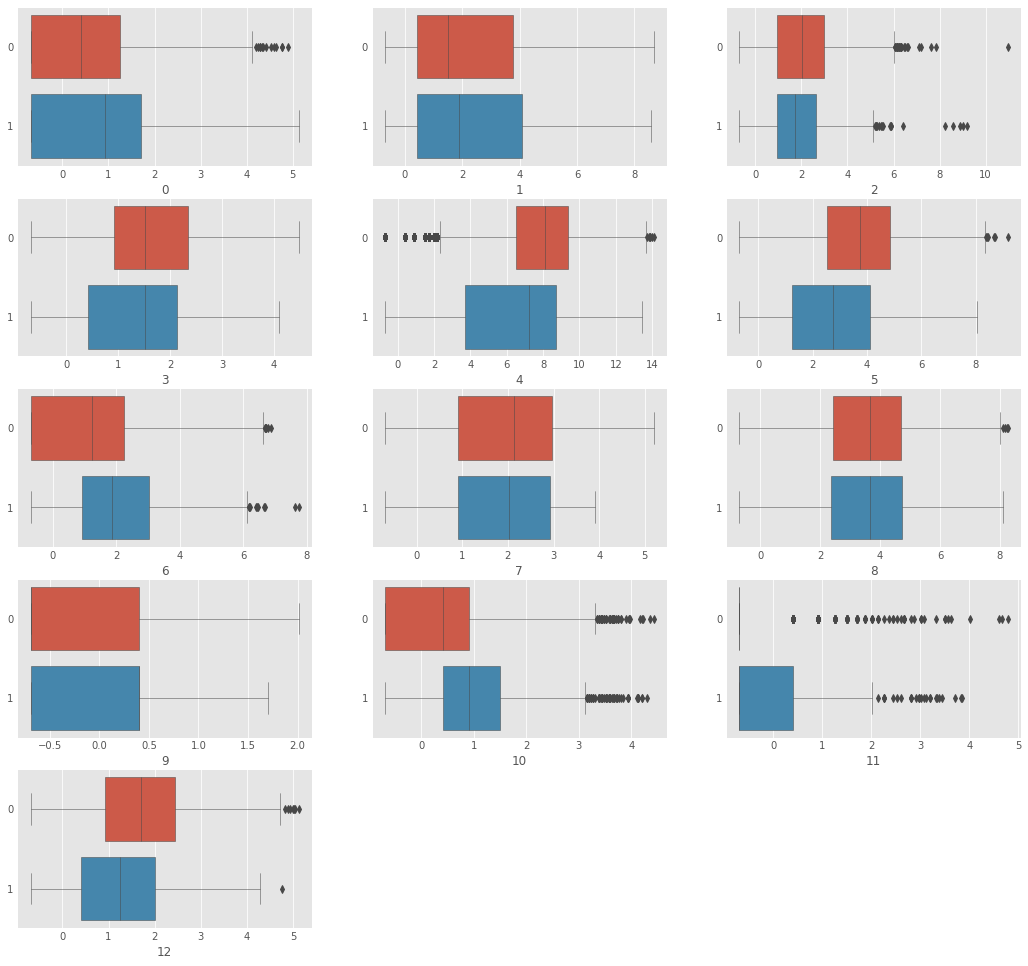

In [7]:
plt.figure(figsize=(18, 45))
for i in numeric_df:
    x = numeric_df[i]
    plt.subplot(len(numeric_df.columns), 3, i + 1)
    sb.boxplot(np.log(x + 0.5), labels, orient="h", linewidth=0.5)

plt.show()

Lastly, we'll see if the distributions of categories are different per class. For categorical data, this can be accomplished with a χ² test. This test assumes that the 2 groups are independent (null hypothesis). First we put the category distributions in a [contingency table](https://en.wikipedia.org/wiki/Contingency_table). Then, we compare each distribution with the "expected distribution", and add up the differences to get the chi-statistic. This number follows a χ² distribution. We can compute a p-value as potential evidence against the null hypothesis.

Most of the p-values are 0 or very close to 0. This means there are differences in the distributions of categories per class. This is good news, as it suggests we might use these to make a prediction. 

**NOTE:** Actually, I'm a little skeptical of this result. In my opinion, the χ² test rejects the null hypothesis too easily when there are some very small counts. Since there are a lot of rare categories, many of these columns have this *long tail* of rare counts. This may reject the null hypothesis, but would not imply prospects for predictive modeling.

In [47]:
col_names = []
chi2s = []
p_vals = []

for col_name, category_counts in category_count_data.items():
    neg_distribution = np.array([counts["neg"] for counts in category_counts.values()])
    pos_distribution = np.array([counts["pos"] for counts in category_counts.values()])
    chi2, p_val, _, expected = chi2_contingency([neg_distribution, pos_distribution])
    col_names.append(col_name)
    chi2s.append(chi2)
    p_vals.append(p_val)

chi2_test_df = pd.DataFrame({ "column": col_names, "χ²": chi2s, "p value": p_vals })
chi2_test_df

,column,χ²,p value
0,C0,57.634823,9.197836e-01
1,C22,1743.230967,0.000000e+00
2,C1,2519.274379,0.000000e+00
3,C17,2270.030955,0.000000e+00
4,C21,114.102383,1.291746e-21
5,C15,1891.177506,0.000000e+00
6,C8,1059.035454,1.079874e-230
7,C5,148.987757,6.623175e-29
8,C9,1150.053148,1.189559e-192
9,C23,2072.582861,0.000000e+00


## Summary of Insights

- Some columns have no nulls or very few, while others have many. Sometimes columns have nulls correlated with other columns. We won't be able to simply omit rows with missing data. In order to avoid having to impute meaningful values, we can use decision-tree-based models for their ability to handle NULLs.
- Most numerical values are very right-skewed. This is another good reason to chose decision trees, as they don't require transformation of the data.
- There are some outlying negative values in the second integer column, but it's a very small percentage. This can be ignored. There don't seem to be any coding errors.
- There is little correlation bewteen the numerical columns. This is good, as it means there is little redundancy.
- The categorical columns consist mostly of a disarrangement of rare cetegories, i.e. most of the unique categories only show up in the data few times. This is not good. We can take all the rare categories and replace them with a special value (keeping only the top-k categories in each column), but that will remove some useful information. It also introduces another hyper-parameter, k.
- The classes are imbalanced. About 75% of the examples are negative. This will cause the models we train to favor high accuracy on the majority class unless we can weight the examples or re-sample.
- Not much evidence of any columns correlating strongly with the target, unfortunately.

## Algorithm Explanation

### Algorithm Comparison

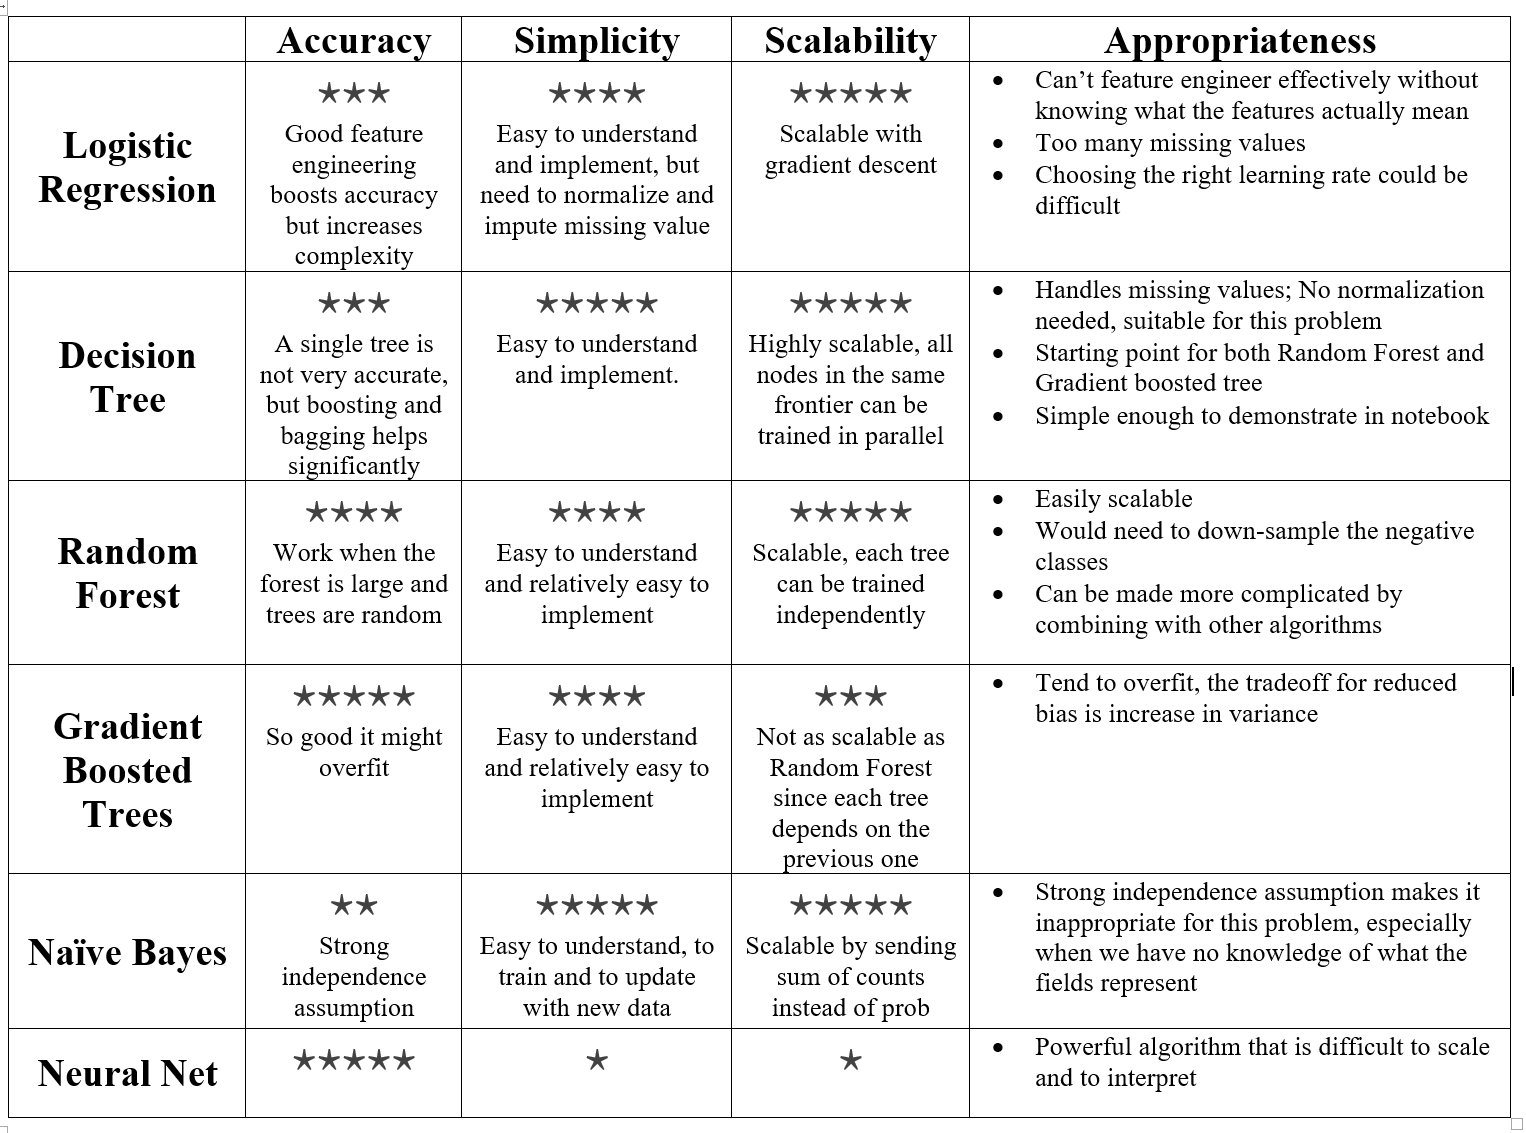

In [2]:
from IPython.display import Image
Image(filename="images/Model Comparison.PNG")

Since decision trees are easy to understand, simple to demonstrate and serves at the basis for two other powerful algorithms while remaining scalable, we will demonstrate the basic of decision trees in the following section

### Toy Example

## Algorithm Implementation

### Feature Hashing

Due to the massive feature space for categorical data (as realized in our EDA), we will implement a hashing trick.  This will do two things for us, the first is to convert the anonamized categorical data from strings into a numeric type.  The next, in order to reduce the feature space, we apply a hash function, in this case a simple modulus operation, to reduce the feature size to 16 bits.  Since the data is anonamized, it is impractical to come up with a "logical" hash function to group "like" categories, so in order to reduce our feature space and improve our model run-time, this will suffice.  Working with real, non-anomamized data, we would approach this in a more practical manner.

In [5]:
# define the hash trick to convert string features to numeric and reduce the feature space
# take a row of features and the label
# leave features 0-13 the same (already integers), covert and hash features 
def hashTrick(features, label, N):
    newFeatures = list(features[0:13])
    for i in range(14, len(features)):
        if features[i] == None:
            newFeatures += list([None])
        else:
            newFeatures += list([int(features[i], 16) % 2**N])
    yield (newFeatures, label)

## Decision Trees

#### **This section contains a simplified version that helps to demonstrate the concept of a tree. For a more complete and effective home-grown implementation of decision trees, please see the section on home-grown trees. Final models are boosted and/or bagged trees in MLIB**

## Step1: Create a toy dataset using values from the actual dataset
1. Actual dataset has plenty of null values, can treat nulls as a seperate category
2. Actual dataset has a large number of distinct values in some fields. As a result the parameter space is huge. Hashing trick needed
3. Column 3 & 4 uses values from the first two categorical columns in data
4. Rebalanced dataset. Original data has disporportional number of negative classes which would make algorithms inaccurate
5. Numerical fields treated as categories for simplicity for this toy demonstration

### MLlib Implementation

### Ensembles of Trees

The numerical columns are pretty much used directly. Note that NULLs are encoded with the value -10 (also tried 0 and imputing with the medians). Categorical values are converted into numerical data using the hashing trick.

In [7]:
def to_labeled(pair):
    """transform input data into the features"""
    row, label = pair
    # collect the converted values here
    vector = []
    
    for i, val in enumerate(row):
        # if this is an numerical column
        if val is None:
            val = -10
        vector.append(val)
    return LabeledPoint(label, vector)

def resample(pair):
    """sample the positive examples twice to increase their importance"""
    if pair.label == 1:
        return [pair, pair]
    else:
        return [pair]

labeledRDD = dataRDD.map(to_labeled)

# set model params
categoricalFeaturesInfo = { int(feat[1:]) + 13: count + 2 for feat, count in num_significant_categories.items() }
maxBins = max(num_significant_categories.values()) + 2
trainingData, validationData = labeledRDD.randomSplit([0.9, 0.1])
# re-samples the positive class
#trainingData = trainingData.flatMap(resample)

labels = validationData.map(lambda lp: lp.label).collect()

In [20]:
def trainGBT(trainingData, maxBins, maxDepth, numIterations):

    model_gbdt = GradientBoostedTrees.trainClassifier(trainingData,
                                                      categoricalFeaturesInfo={},
                                                      maxBins=maxBins,
                                                      maxDepth=8,
                                                      numIterations=10) # how many trees

    # Evaluate model on test instances and compute validation accuracy
    predictions_gbdt = model_gbdt.predict(validationData.map(lambda x: x.features))
    #labelsAndPredictions = validationData.map(lambda lp: lp.label).zip(predictions)
    #testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(validationData.count())

    preds_gbdt = predictions_gbdt.collect()
    accuracy_gbdt = np.mean(np.array(labels) == np.array(preds_gbdt))
    print('accuracy = ' + str(accuracy_gbdt))

    model_name = "models/gbdt-model"
    # save the model
    !rm -rf /media/notebooks/{model_name}
    model_gbdt.save(sc, model_name)

    # how to load the model again, tho not necessary in this file
    #sameModel = GradientBoostedTreesModel.load(sc, model_name)
    #print(sameModel.toDebugString())
    
    return (labels, preds_gbdt)

In [22]:
# loop through various combinations of tree depth, bins, and iterations
# this will help us hone in on which parameters to use for our final model
for td in range(3,12,3):
    for b in range(10, maxBins,5):
        for i in range(5,12,4):
            print("Depth = " + str(td) + ", Max Bins = " + str(b) + ", Iterations = " + str(i))
            (labels, preds_gbdt) = trainGBT(trainingData, b, td, i)
            print(classification_report(labels, preds_gbdt))
            print(confusion_matrix(labels, preds_gbdt))
            print("")

Depth = 3, Max Bins = 10, Iterations = 5
accuracy = 0.7691511387163561
             precision    recall  f1-score   support

        0.0       0.81      0.92      0.86       745
        1.0       0.49      0.26      0.34       221

avg / total       0.73      0.77      0.74       966

[[686  59]
 [164  57]]

Depth = 3, Max Bins = 10, Iterations = 9
accuracy = 0.7691511387163561
             precision    recall  f1-score   support

        0.0       0.81      0.92      0.86       745
        1.0       0.49      0.26      0.34       221

avg / total       0.73      0.77      0.74       966

[[686  59]
 [164  57]]

Depth = 3, Max Bins = 15, Iterations = 5
accuracy = 0.7484472049689441
             precision    recall  f1-score   support

        0.0       0.79      0.92      0.85       745
        1.0       0.38      0.15      0.22       221

avg / total       0.69      0.75      0.71       966

[[689  56]
 [187  34]]

Depth = 3, Max Bins = 15, Iterations = 9
accuracy = 0.7484472049689441

In [11]:
def trainRF(trainingData, maxBins, numClasses, maxDepth, numTrees):
    model_rf = RandomForest.trainClassifier(trainingData,
                                        categoricalFeaturesInfo={},
                                        maxBins=maxBins,
                                        numClasses=numClasses,
                                        maxDepth=maxDepth,
                                        numTrees=numTrees)

    # Evaluate model on test instances and compute validation accuracy
    predictions_rf = model_rf.predict(validationData.map(lambda x: x.features))

    preds_rf = predictions_rf.collect()
    accuracy_rf = np.mean(np.array(labels) == np.array(preds_rf))
    print('accuracy = ' + str(accuracy_rf))

    model_name = "models/rf-model"
    # save the model
    !rm -rf /media/notebooks/{model_name}
    model_rf.save(sc, model_name)
    
    return (labels, preds_rf)

#trainRF(trainingData, maxBins, 2, 15, 10)

In [13]:
for b in range(maxBins, maxBins+1):
    for d in range(5,26,3):
        for t in range(10,51,5):
            print("Max Bins = " + str(b) + ", Max Depth = " + str(d) + ", Num Trees = " + str(t))
            (labels, preds_rf) = trainRF(trainingData, b, 2, d, t)
            print(classification_report(labels, preds_rf))
            print(confusion_matrix(labels, preds_rf))
            print("")

Max Bins = 52, Max Depth = 5, Num Trees = 10
accuracy = 0.7727272727272727
             precision    recall  f1-score   support

        0.0       0.78      0.99      0.87       800
        1.0       0.47      0.03      0.06       234

avg / total       0.71      0.77      0.69      1034

[[792   8]
 [227   7]]

Max Bins = 52, Max Depth = 5, Num Trees = 15
accuracy = 0.7775628626692457
             precision    recall  f1-score   support

        0.0       0.78      0.99      0.87       800
        1.0       0.60      0.05      0.09       234

avg / total       0.74      0.78      0.70      1034

[[792   8]
 [222  12]]

Max Bins = 52, Max Depth = 5, Num Trees = 20
accuracy = 0.7727272727272727
             precision    recall  f1-score   support

        0.0       0.78      0.99      0.87       800
        1.0       0.47      0.03      0.06       234

avg / total       0.71      0.77      0.69      1034

[[791   9]
 [226   8]]

Max Bins = 52, Max Depth = 5, Num Trees = 25
accuracy = 0.

### Using Full Data

In [ ]:
fullRDD = spark.read.csv("data/train.txt", header=False, sep="\t").rdd
fullDataRDD = rawRDD.map(lambda row: ([None if el is None else int(el) for el in row[1:14]] + list(row[14:]), int(row[0]))) \
                    .flatMap(lambda r: hashTrick(r[0], r[1], 16)) \
                    .cache()

In [ ]:
fullLabeledRDD = fullDataRDD.map(to_labeled)

# set model params
# TODO: need this for full data
categoricalFeaturesInfo = { int(feat[1:]) + 13: count + 2 for feat, count in num_significant_categories.items() }
maxBins = max(num_significant_categories.values()) + 2
fullTrainingData, fullValidationData = labeledRDD.randomSplit([0.9, 0.1])
# re-samples the positive class
#trainingData = trainingData.flatMap(resample)

labels = fullValidationData.map(lambda lp: lp.label).collect()

In [ ]:
### Homegrown Implementation

## Applications of Course Concepts